In [25]:
import numpy as np
from load_train_data import decodeAllData1
import matplotlib.pyplot as plt
import random
import struct

# S型函数
def Sigmoid(x):
    ans = 1.0/(1.0+np.exp(-x))
    return ans

# S型函数导数
def SigmoidDeriv(x):
    return Sigmoid(x)*(1-Sigmoid(x))

def softMax(x):
    return np.exp(x)/np.sum(np.exp(x))

def softMaxDeriv(x):
    return softMax(x) * (1-softMax(x))

# 双曲正切函数
def tanh(x):
    return np.tanh(x)

# 双曲函数导数
def tanhDeriv(x):
    return 1.0 - np.tanh(x) * np.tanh(x)

#损失函数
def lossFun(y,yhat):
    return -y*np.log(yhat) - (1-y)*np.log(1-yhat)

#损失函数导
def lossFunDeriv(y,yhat):
    return yhat-y

#线性激活函数
def linear(x):
    return x
#线性激活函数导数
def linearDeriv(x):
    return 1

activationMap = {}
activationDerivMap = {}
activationMap['tanh'] = tanh
activationMap['sigmoid'] = Sigmoid
activationMap['softMax'] = softMax
activationMap['linear'] = linear
activationDerivMap['tanh'] = tanhDeriv
activationDerivMap['sigmoid'] = SigmoidDeriv
activationDerivMap['softMax'] = softMaxDeriv
activationDerivMap['linear'] = linearDeriv

class Params:
    def __init__(self):
        self.rate = 0
        self.landa = 0
        self.m = 0
        self.L1 = 0

    def setLanda(self,landa):
        self.landa = landa
        if(self.m!=0):
            self.L1 = ((1.0/self.m) * self.landa)

    def setM(self,m):
        self.m = m
        if(self.m==0):
            raise Exception("set data len is zero")
        self.L1 = ((1.0/self.m) * self.landa)

    def setRate(self,rate):
        self.rate = rate

    def l1(self,weight):
        return  self.L1 * weight

class Layer:
    def __init__(self,units:int,activation) -> None:
        if(activationMap[activation]==None):
            raise Exception("activation not exist")
        self.Z = np.ndarray((1,1))
        self.activationFlag = activation
        self.units = units
        self.bais = np.ones((units,1))
        self.weight = np.ndarray((1,1))
        self.activation = activationMap[activation]
        self.activationDeriv = activationDerivMap[activation]
        self.preLayer = None
        self.nextLayer = None
        self.params = None

    def initParams(self,params):
        self.params = params

    def forword(self,input):
        self.input = input
        self.Z = self.weight.dot(input) + self.bais
        return self.activation(self.Z)

    def backword(self,bp):
        bp = bp * self.activationDeriv(self.Z)
        self.weight -= self.params.rate * np.matmul(bp,self.input.T) - self.params.l1(self.weight)
        self.bais -= self.params.rate * bp - self.params.l1(self.bais)
        return self.weight.T.dot(bp)

        
class NeuralNetworkModel:

    def __init__(self,layers:np.ndarray) -> None:
        self.layers = layers
        self.lossArray = []
        self.lastLayer = layers[-1]
        self.firstLayer = layers[0]
        layer = None
        for i in range(len(layers)):
            nextLayer = layers[i]
            nextLayer.preLayer = layer
            if(layer!=None):
                layer.nextLayer = nextLayer
            layer = layers[i]
        self.init = False
        self.params = None
    
    def compile(self,learnRate,landa,loss,lossDeriv):
        if(self.params==None):
            self.params = Params()
        self.params.setRate(learnRate)
        self.params.setLanda(landa)
        self.loss = loss
        self.lossDeriv = lossDeriv

    def defaultWeight(self):
        pass

    def fit(self,data,label,epochs):
        self.__initWeight(self.layers,data)
        banch = int(epochs/30);
        self.lossArray = np.ndarray(int(epochs/banch))
        trainBanch = 0
        banchLoss = 0
        lossIndex = 0
        print("banch="+str(trainBanch))
        for i in range(epochs):
            if trainBanch>=banch:
                self.lossArray[lossIndex]  = banchLoss*(1.0/banch)
                trainBanch = 0
                banchLoss = 0
                lossIndex+=1
            X = np.asarray([data[i]]).T
            Y = np.asarray([label[i]]).T
            yHat = self.forword(X)
            bp = self.lossDeriv(Y,yHat)
            self.backworkd(bp)
            banchLoss += np.sum(self.loss(Y,yHat))
            trainBanch+=1
            
            

    def __initWeight(self,layers,data):
        if self.init==False:
            self.init = True
            inputDimention = data.shape[1]
            dataLen = len(data[0])
            if(dataLen==0):
                raise Exception("data length is Zero")
            self.params.setM(len(data[0]))
            if len(layers)<=0:
                raise Exception("error: layer is zero")
            currentLayer = self.firstLayer
            while currentLayer!=None:
                currentLayer.initParams(self.params)
                currentLayer.weight = np.random.rand(currentLayer.units,inputDimention) * 0.5 - 0.25
                inputDimention = currentLayer.units
                currentLayer = currentLayer.nextLayer
        else:
            print("alread init")
    

    def forword(self,X):
        V = X
        currentLayer = self.firstLayer
        while currentLayer!=None:
            V = currentLayer.forword(V)
            currentLayer = currentLayer.nextLayer
        return V

    def backworkd(self,bp):
        currentLayer = self.lastLayer
        while currentLayer!=None:
            bp = currentLayer.backword(bp)
            currentLayer = currentLayer.preLayer

    def predict(self,X):
        V = X
        currentLayer = self.firstLayer
        while currentLayer!=None:
            Z = currentLayer.weight.dot(V)
            V = currentLayer.activation(Z)
            currentLayer = currentLayer.nextLayer
        ans = 0
        for i in range(len(V)):
            if(V[i]>V[ans]):
                ans = i
        return (ans,V[ans],V)
    
    def saveModel(self):
        modelFile = open("model.ml",mode='wb+')
        currentLayer = self.firstLayer
        layerCount = len(self.layers)
        modelFile.write(struct.pack('<I',layerCount))#层数
        while(currentLayer!=None):
            weight = currentLayer.weight
            bais = currentLayer.bais
            shape = weight.shape
            row = shape[0]
            column = shape[1]
            modelFile.write(struct.pack('<I',row))#行
            modelFile.write(struct.pack('<I',column))#列
            activationFlag = 0;
            if currentLayer.activationFlag=='tanh':
                activationFlag = 1
            if currentLayer.activationFlag=='sigmoid':
                activationFlag = 2
            if currentLayer.activationFlag=='softMax':
                activationFlag = 3
            if currentLayer.activationFlag=='linear':
                activationFlag = 4
            modelFile.write(struct.pack('<I',activationFlag))
            print(weight[0,1])
            for j in range(column):
                for i in range(row):
                    modelFile.write(struct.pack('<d',weight[i,j]))
            for i in range(row):
                modelFile.write(struct.pack('<d',bais[i,0]))
            currentLayer = currentLayer.nextLayer

        modelFile.flush()    
        modelFile.close()
        pass


In [26]:
X,Y,T_X,T_Y = decodeAllData1()

魔数:2051,图片数量:60000,图片大小:28*28
47040000
魔数:2049,测试集数量:60000
魔数:2051,图片数量:10000,图片大小:28*28
7840000
魔数:2049,测试集数量:10000


In [27]:
def trainSetTest(model):
    sCount = 0
    dataCount = len(X)
    for i in range(dataCount):
        predict = model.predict(X[i])[0]
        labelY = np.asarray(range(10)).dot(Y[i])
        if(predict==labelY):
            sCount +=1
    print("训练集准确率"+str((sCount/dataCount)*100.0)+"%")
def testSetTest(model):
    sCount = 0
    testCount = len(T_X)
    for i in range(testCount):
        predict = model.predict(T_X[i])[0]
        labelY = T_Y[i]
        if(predict==labelY):
            sCount +=1
    print("测试集准确率"+str((sCount/testCount)*100.0)+"%")

In [28]:
X,Y,T_X,T_Y = decodeAllData1()
dataCount = 60000
a = np.ndarray((dataCount,784))
b = np.ndarray((dataCount,10))
for i in range(dataCount):
    a[i] = X[i].T[0]
    b[i] = Y[i].T[0]

魔数:2051,图片数量:60000,图片大小:28*28
47040000
魔数:2049,测试集数量:60000
魔数:2051,图片数量:10000,图片大小:28*28
7840000
魔数:2049,测试集数量:10000


banch=0
训练集准确率91.29333333333334%
测试集准确率91.43%


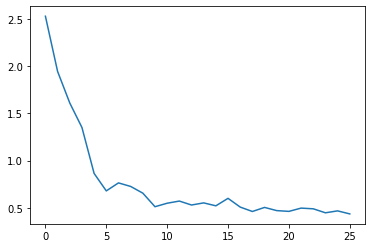

In [29]:
#这里调整,隐藏层和激活函数,还有学习速率和正则项试试(正则项用于防止过拟合,原理是惩罚w参数不能太大)
model = NeuralNetworkModel([Layer(64,'sigmoid'),Layer(10,'softMax')])
model.compile(learnRate = 0.10,landa=0.0001,loss = lossFun,lossDeriv = lossFunDeriv)
model.fit(a,b,dataCount)
plt.plot(model.lossArray[0:26])
trainSetTest(model)
testSetTest(model)

alread init
banch=0
训练集准确率92.97666666666666%
测试集准确率92.91%
alread init
banch=0
训练集准确率93.89833333333333%
测试集准确率93.78%


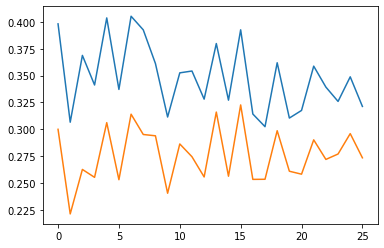

In [30]:
#多训练几次看看结果
train_count = 2
if(train_count>0):
    for i in range(train_count):
        model.fit(a,b,dataCount)
        plt.plot(model.lossArray[0:26])
        trainSetTest(model)
        testSetTest(model)

In [31]:
#模型保存起来
model.saveModel()
testIndex = random.randint(0,dataCount)
predictY,probability,outArr = model.predict(a[testIndex])
print("预测结果%d,概率%f"%(predictY,probability))
print("实际结果%d"%(int(np.asarray(range(10)).dot(b[testIndex].T))))

0.09927556171094473
1.7068546256530321
预测结果4,概率0.962323
实际结果4


predict=4
99.5907868994%
[1.93329573e-05 6.68500683e-07 5.48974289e-04 4.39640221e-06
 9.95907869e-01 2.55355184e-07 1.15641850e-04 2.18174560e-05
 2.78164284e-04 3.10287991e-03]
4.0


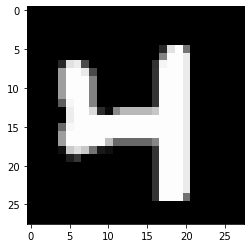

In [32]:
#随机刷新一下,看看你的模型预测的怎么样
testIndex = random.randint(0,dataCount)
sCount = 0
yHat = model.predict(a[testIndex])
testa = a[testIndex]
plt.imshow(np.asarray(a[testIndex]).reshape((28,28)),cmap="gray")
print("predict="+str(yHat[0])+"\n"+str(yHat[1]*100)+"%\n"+str(yHat[2]))
print(np.asarray(range(10)).dot(b[testIndex].T))

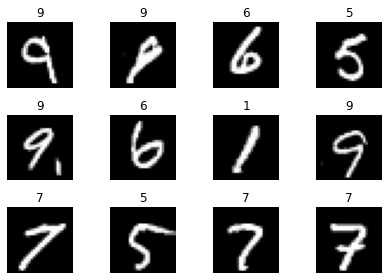

In [33]:
def display_multiple_img(images, rows = 1, cols=1):
    figure, ax = plt.subplots(nrows=rows,ncols=cols )
    for ind,title in enumerate(images):
        ax.ravel()[ind].imshow(images[title],cmap="gray")
        ax.ravel()[ind].set_title(int(np.asarray(range(10)).dot(b[int(title)].T)))
        # ax.ravel()[ind].set_title(title)
        ax.ravel()[ind].set_axis_off()
    plt.tight_layout()
    plt.show()

randIndex = []
for i in range(12):
    testIndex = random.randint(0,dataCount)
    randIndex.append(testIndex)
tmpImages = {str(i):a[i].reshape((28,28)) for i in randIndex}
display_multiple_img(tmpImages,3,4)

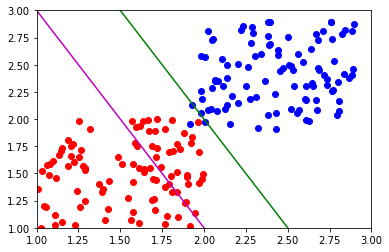

In [34]:
x1 = np.ones(100)
x2 = np.ones(100)
x1 += np.random.rand(100)
x2 += np.random.rand(100)

y1 = np.ones(100)*1.9
y2 = np.ones(100)*1.9
y1 += np.random.rand(100)
y2 += np.random.rand(100)


fig = plt.figure()
ax = fig.gca()
md = np.mgrid[1:3:10j]
m = -2*md + 6;

md1 = np.mgrid[1:3:10j]
m1 = -2*md1 + 5;
ax.scatter(x1,x2,c='r')
ax.scatter(y1,y2,c='b')
ax.plot(md,m,c='g',alpha=1)
ax.plot(md1,m1,c='m',alpha=1)
ax.axis([1,3,1,3])
plt.show()

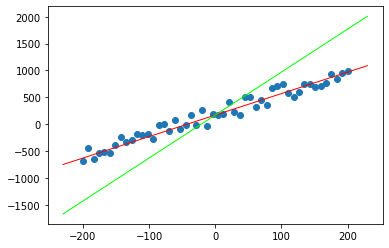

In [35]:
x = np.mgrid[-200:200:50j]
z = 4*x;
md = np.mgrid[-230:230:55j]
m = 4*md + 170
md2 = np.mgrid[-230:230:55j]
m2 = 8*md +170
z += np.random.rand(z.size)*350
fig = plt.figure()
ax = fig.gca()
ax.plot(md,m,linewidth=1,c="#ff0000",alpha=1)
ax.plot(md2,m2,linewidth=1,c="#00ff00",alpha=1)
ax.scatter(x,z)
plt.show()

C:\Users\lzp_w\AppData\Local\Temp/ipykernel_30460/3295384210.py:4: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


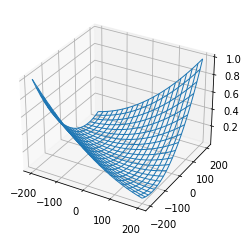

In [36]:
u, v = np.mgrid[-200:200:100j, -200:200:100j]
z = (2*u+3*v-3)**2
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_wireframe(u,v,z,rstride=5,cstride=5,linewidth=1)
plt.show()

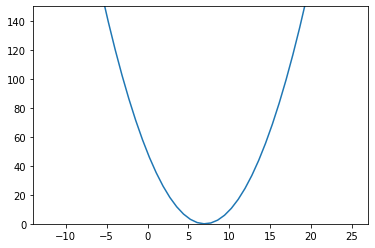

In [37]:
x = np.mgrid[-14:27:50j]
z = (x-7)**2
fig = plt.figure()
ax = fig.gca()
ax.axis([-14,27,0,150])
ax.plot(x,z)
plt.show()